# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in training set(These images have labels).
* There are around 10,000+ images in test set(These images have no labels because we'll want to predict them).

In [0]:
# Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

###Get our workspace ready

* Import TensorFlow 2.x✅
* Import TensorFlow Hub
* Make sure we're using a GPU

In [0]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :( ") 

TF version: 2.2.0
TF Hub version: 0.8.0
GPU available (YESSSSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representation).

Let's start by accessing our data and checking out the labels.

In [0]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     3fe38b30abae7147cf67ce083389943e  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [0]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


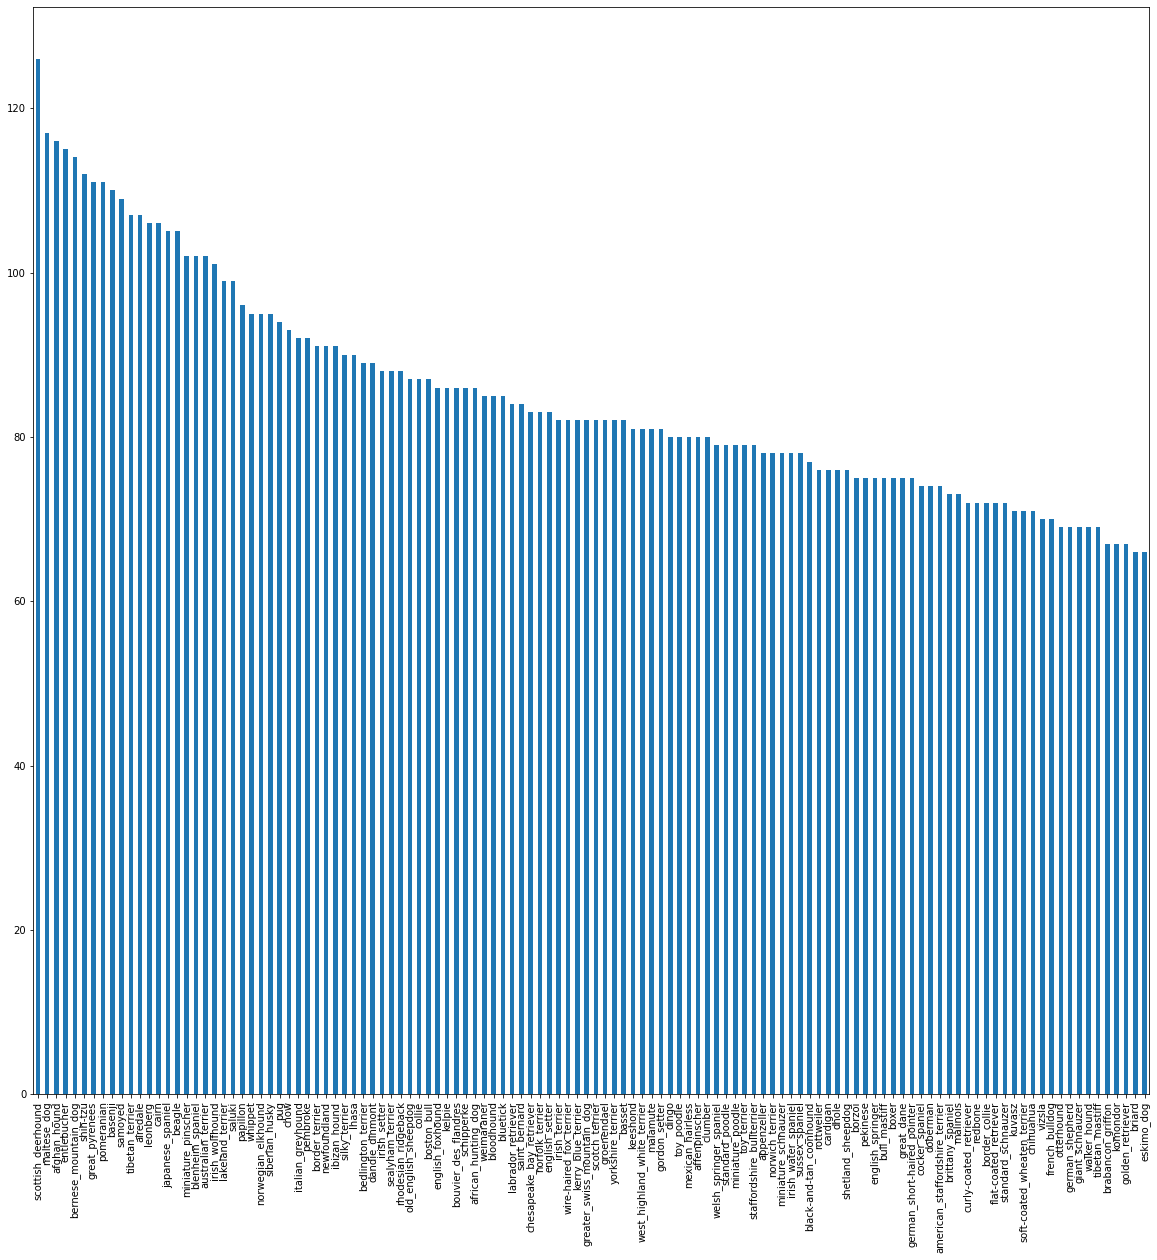

In [0]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 20))

In [0]:
labels_csv["breed"].value_counts().median()

82.0

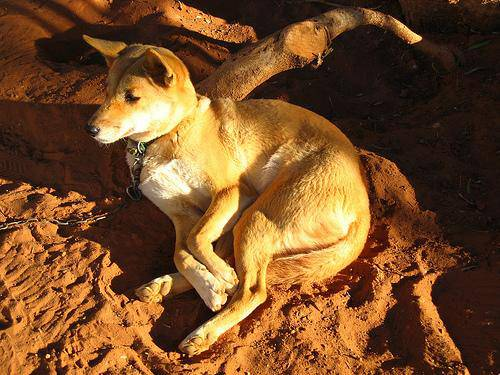

In [0]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames. 

In [0]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [0]:
import os
os.listdir("drive/My Drive/Dog Vision/train")[:10]

['f59c6ac65a3b996404ccce16dad310e0.jpg',
 'ea5be84db93c42752547df879813ce47.jpg',
 'e9aaa8964f450f990a7a3c4228bb844d.jpg',
 'f3d98aab47dfabd6c98750f45f6c4038.jpg',
 'ed9c22ad21413691f548f5d72e7a76d9.jpg',
 'f5ced876dc38fce8230cb1c721e29973.jpg',
 'f52a0aaff41a517be216bf41c967a751.jpg',
 'efeeefcc693ae837060c1c103195c4a6.jpg',
 'ef80922725c7fb9865005222ef30714e.jpg',
 'f5379f2502e90983e6361d4acdf0a56e.jpg']

In [0]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files!!! Proceed.


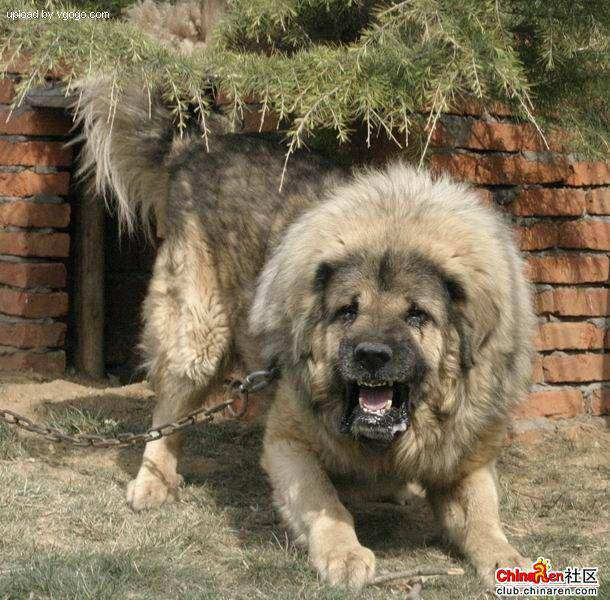

In [0]:
# Check
Image(filenames[9000])

In [0]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list, let's prepare our labels. 

In [0]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) does the same thing as above
labels
len(labels)

10222

In [0]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels do not match number of filenames, check data directories")

Number of labels matches number of filenames!


In [0]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [0]:
# Turn a  single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [0]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
len(boolean_labels)

10222

In [0]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int))  # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [0]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


###Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [0]:
# Setup X & y variales
X = filenames
y = boolean_labels

We're going to start off experimeting with ~1000 images and increase as needed.

In [0]:
# Set number of images to use for expeimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [0]:
 # Let's split our data into train and validation sets
 from sklearn.model_selection import train_test_split

 # Split them into training and validation of total size NUM_IMAGES
 X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size=0.2,
                                                   random_state=42)
 
 len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [0]:
# Let's have a look at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

### Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensoFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `imgae` to be a shape of (224, 224)
5. Return the modifies `image`

In [0]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [0]:
# Turn image into a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(imgae_path, img_size=IMG_SIZE):
  """
  Take an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(imgae_path)
  # Turn the jpg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value(224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE] )

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size of images at a time `you can manually adjust the batch size if need be`).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label)


In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Take an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [0]:
# Demo of the above
(process_image(X[42], tf.constant(y[42])))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

Now we've got a way to turn our data into tuples of Tensors in the form: (`image, label`), let's make a function to turn all of our dat(`X` & `y`) into batches!

In [0]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no lables).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
                                                              
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches..")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
                                              
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x)) 
    # Create (image, label) tuples (this also turns the iamge path inot a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [0]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches..
Creating validation data batches..


In [0]:
# Check out the differetn attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them

In [0]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    #plt.axis("off")

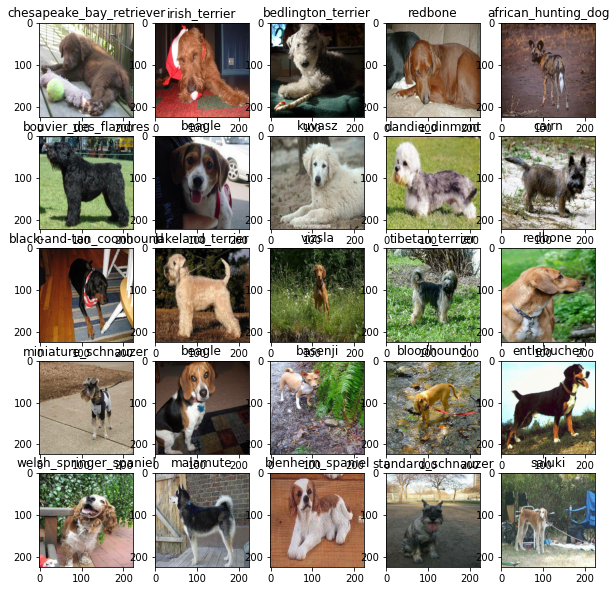

In [0]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

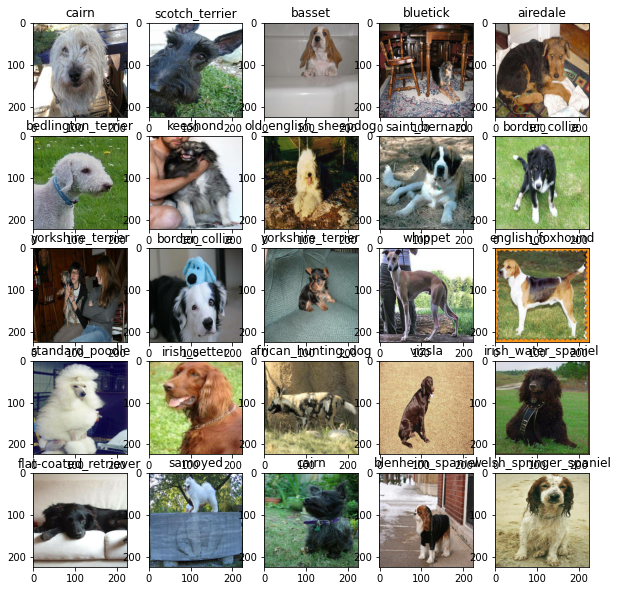

In [0]:
# Now let's visualize our validaion set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define :
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use. From TensorFlowHub-
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height , width, colout channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion(do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model(tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [0]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax")  # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"] 
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [0]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create 2 callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function(we'll do this after model training).

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an expetiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop out model from overfitting by stopping training if a certain evaluation metric stops improving.
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=en

In [0]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [0]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YES!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YES!!!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tenosrboard_callback()`
* Call the `fit()` function on our model passing it the  training data, validation data, number of epochs to train for(`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # Create a model 
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [0]:
# Fit the model to the data
model  = train_model() 

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 516s 21s/step - loss: 4.5272 - accuracy: 0.1013 - val_loss: 3.2872 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 5s 183ms/step - loss: 1.6119 - accuracy: 0.7063 - val_loss: 2.1057 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 5s 187ms/step - loss: 0.5573 - accuracy: 0.9413 - val_loss: 1.6154 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 5s 189ms/step - loss: 0.2509 - accuracy: 0.9837 - val_loss: 1.4415 - val_accuracy: 0.6500
Epoch 5/100
25/25 [==============================] - 5s 186ms/step - loss: 0.1458 - accuracy: 0.9975 - val_loss: 1.3753 - val_accuracy: 0.6600
Epoch 6/100
25/25 [==============================] - 5s 184ms/step - loss: 0.1004 - accuracy: 0.9975 - val_loss: 1.3327 - val_accuracy: 0.6600
Epoch 7/100
25/25 [==============================

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directly we created earlier and visualize its contents.

In [0]:
#%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs/

## Making and evaluating predictions using a trained model

In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 114ms/step


array([[6.8347616e-04, 1.3735201e-04, 1.2804563e-03, ..., 7.1447639e-04,
        4.1647207e-05, 1.1729487e-03],
       [1.2693248e-03, 2.4532684e-04, 4.9036457e-03, ..., 1.1675922e-03,
        1.0269042e-03, 7.4812611e-05],
       [3.4371794e-06, 4.6045584e-06, 2.0712620e-05, ..., 3.7828435e-05,
        3.2726697e-05, 9.4383821e-04],
       ...,
       [3.2648861e-06, 4.8394730e-05, 4.1218771e-04, ..., 8.4346821e-06,
        2.0177109e-04, 1.3097105e-04],
       [1.8245237e-03, 3.5897139e-04, 4.7366491e-05, ..., 1.8617969e-04,
        7.3413221e-06, 5.3671882e-03],
       [4.5658264e-04, 7.3359156e-06, 2.5534888e-03, ..., 3.2107928e-03,
        3.7159276e-04, 1.2703643e-04]], dtype=float32)

In [0]:
# First prediction
index=42
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[6.83476159e-04 1.37352006e-04 1.28045632e-03 6.93062102e-05
 7.46913720e-05 8.21725844e-05 3.21856700e-02 2.71449884e-04
 6.16056059e-05 2.84386845e-03 5.49306918e-04 1.33588735e-04
 2.41428963e-04 6.18162958e-05 6.67218526e-04 1.38439832e-03
 6.99708617e-05 1.66698501e-01 9.38289577e-06 9.20769889e-06
 1.07947868e-04 1.74418848e-04 1.97409136e-05 3.18581099e-03
 3.16021828e-06 7.07531362e-05 2.30570734e-01 1.16232832e-05
 4.33800917e-04 5.87733579e-04 3.83948238e-04 1.36272528e-03
 1.52832037e-03 2.25500989e-05 1.06195315e-04 4.86635640e-02
 1.38033447e-05 1.96000241e-04 3.52231931e-04 1.15108058e-04
 1.92374038e-03 2.81739722e-05 1.12756257e-04 1.11276138e-04
 5.03029041e-05 7.69624457e-05 1.70222440e-04 1.21855643e-04
 4.63003031e-04 1.80304734e-04 3.03502347e-05 9.59325116e-05
 1.02075865e-03 1.50987951e-04 2.96004182e-05 3.02443397e-04
 8.07955686e-04 2.28910614e-03 6.17949292e-04 5.12402020e-02
 8.60500848e-04 7.55225337e-05 2.32023699e-03 3.83888364e-05
 1.85514611e-04 1.123709

In [0]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilites
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Since our validation data is still in a batch dataset, we'll have to unbatch it to make predictions on the validation images and them compare those predictions to the validationlabels(truth labels).

In [0]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data) 
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to be predicted, probability of predictoin and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

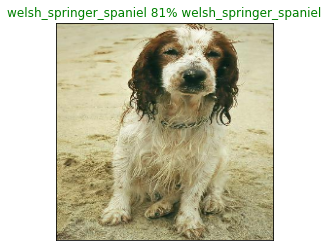

In [0]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=24)

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest predictoin confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10Ppred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 predictions confidence values
  top_10_pred_values = pred_prob[top_10Ppred_indexes]
  # Find the top 10 predictions labels
  top_10_pred_labels = unique_breeds[top_10Ppred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change the colour of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

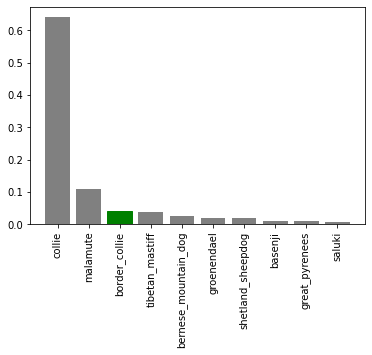

In [0]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

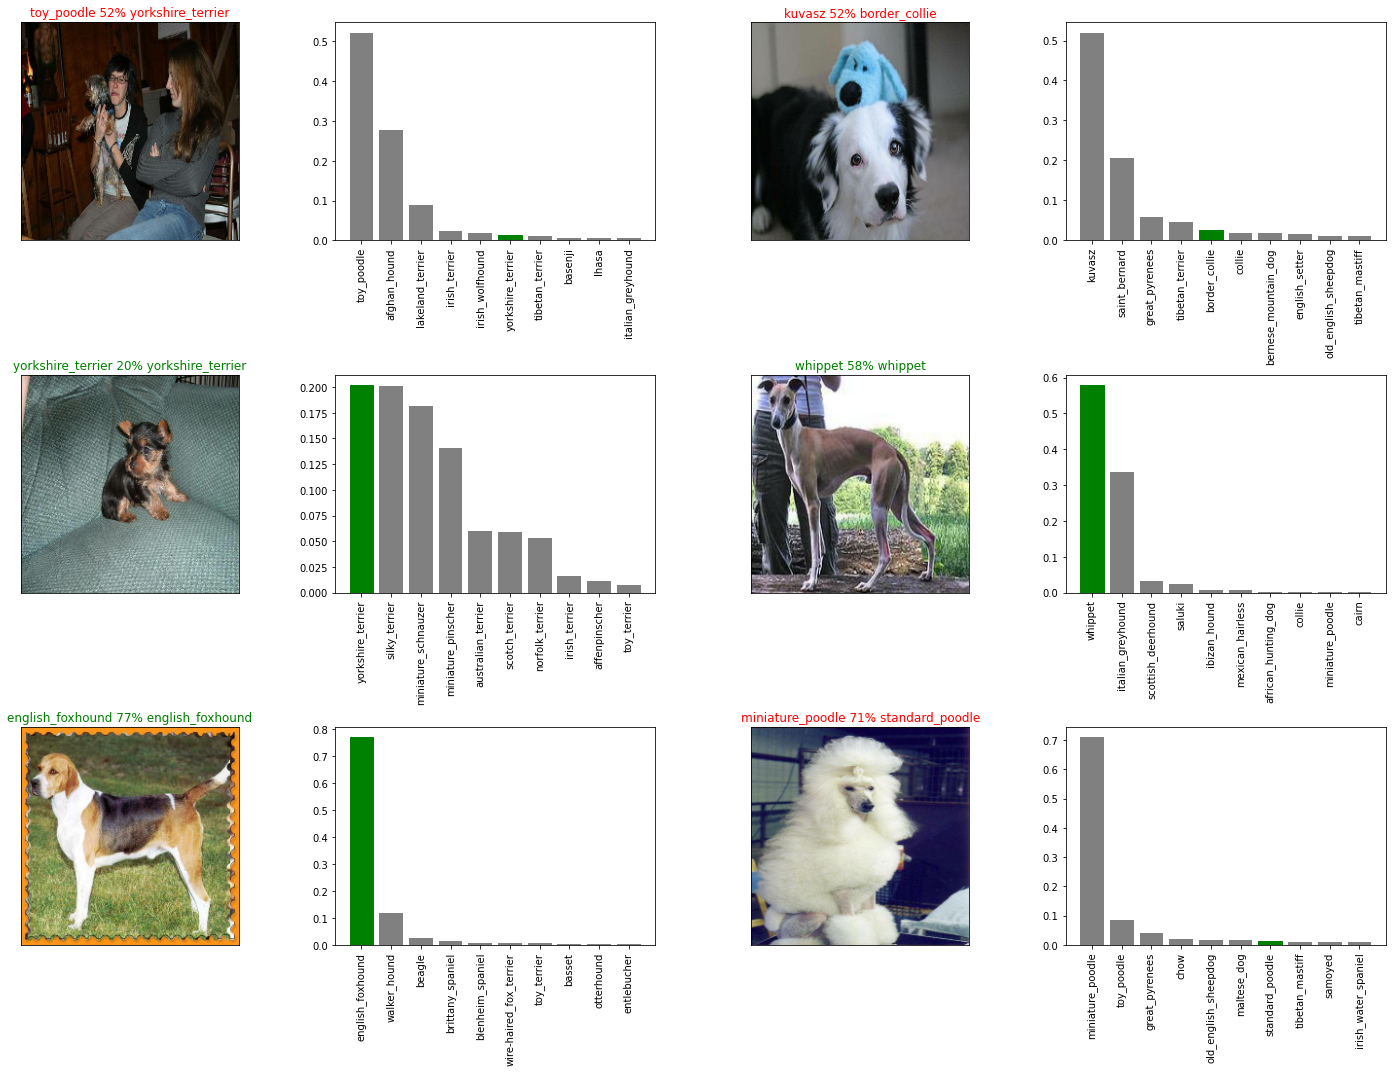

In [0]:
# Let's check out a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Saving and reloading a trained model

In [0]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Save a given model in a models directory and appends a suffix (sting).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}....")
  model.save(model_path)
  return model_path
  

In [0]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [0]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200520-071521-1000-images-mobilenetv2-Adam.h5....


'drive/My Drive/Dog Vision/models/20200520-071521-1000-images-mobilenetv2-Adam.h5'

In [0]:
# Load a trained model
loaded_1000_image_model = load_model("drive/My Drive/Dog Vision/models/20200520-071521-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Dog Vision/models/20200520-071521-1000-images-mobilenetv2-Adam.h5


In [0]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 104ms/step - loss: 1.2099 - accuracy: 0.7000


[1.2098753452301025, 0.699999988079071]

In [0]:
# Evalutate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 112ms/step - loss: 1.2099 - accuracy: 0.7000


[1.2098753452301025, 0.699999988079071]

## Training a big dog model🐶 (on the full data)

In [0]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creating training data batches..


In [0]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

Running the below cell will take a little while (maybe upto **30 minutes** for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [0]:
# Fit the full model on the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 4039s 13s/step - loss: 1.3610 - accuracy: 0.6651
Epoch 2/100
320/320 [==============================] - 67s 208ms/step - loss: 0.4020 - accuracy: 0.8827
Epoch 3/100
320/320 [==============================] - 66s 206ms/step - loss: 0.2367 - accuracy: 0.9352
Epoch 4/100
320/320 [==============================] - 67s 209ms/step - loss: 0.1523 - accuracy: 0.9620
Epoch 5/100
320/320 [==============================] - 67s 209ms/step - loss: 0.1073 - accuracy: 0.9787
Epoch 6/100
320/320 [==============================] - 67s 211ms/step - loss: 0.0782 - accuracy: 0.9859
Epoch 7/100
320/320 [==============================] - 66s 208ms/step - loss: 0.0594 - accuracy: 0.9914
Epoch 8/100
320/320 [==============================] - 67s 209ms/step - loss: 0.0472 - accuracy: 0.9937
Epoch 9/100
320/320 [==============================] - 67s 208ms/step - loss: 0.0370 - accuracy: 0.9961
Epoch 10/100
320/320 [==============================] - 66s 207m

In [0]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200519-085425-full-image-set-mobilenetv2-Adam.h5....


'drive/My Drive/Dog Vision/models/20200519-085425-full-image-set-mobilenetv2-Adam.h5'

In [0]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Dog Vision/models/20200519-085425-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/Dog Vision/models/20200519-085425-full-image-set-mobilenetv2-Adam.h5


 ## Make predictions on the test dataset

 Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the format.

We created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:
* Get the image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [0]:
# Load test image filenames
import os
test_path = '/content/drive/My Drive/Dog Vision/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Dog Vision/test/e9615e7f30ffcf6d705ce9cbcb6d688c.jpg',
 '/content/drive/My Drive/Dog Vision/test/ee7bdce4ac4008b3551ca66f82712e31.jpg',
 '/content/drive/My Drive/Dog Vision/test/e9d0bcd1ca3f651f6693de92d63bce5c.jpg',
 '/content/drive/My Drive/Dog Vision/test/f13508048aa548af116601fa59bd4c62.jpg',
 '/content/drive/My Drive/Dog Vision/test/f39a1f1692b67eb9c92a29f14a07d568.jpg',
 '/content/drive/My Drive/Dog Vision/test/ef627a04965eda29fc3761b1f663aef1.jpg',
 '/content/drive/My Drive/Dog Vision/test/f01df7641b237cd177d71fdb8db9bd58.jpg',
 '/content/drive/My Drive/Dog Vision/test/f1ba2c4a69ed34fea976f8fc6b77f45b.jpg',
 '/content/drive/My Drive/Dog Vision/test/ed0c3f827519441d3d542944978aedad.jpg',
 '/content/drive/My Drive/Dog Vision/test/f07d1123c4259713a46991de0b02ffd0.jpg']

In [0]:
len(test_filenames)

10357

In [0]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches..


Calling `predict()` on full model and passing it the test data batch will take a long time to run (about an hour)

In [0]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 6293s 19s/step


In [0]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [0]:
# Load predictions (NumPy array) from csv file
test_predictoins = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [0]:
test_predictions[:10]

array([[2.7415215e-09, 2.0935647e-11, 2.5763486e-06, ..., 4.1909573e-08,
        7.4141956e-11, 2.0205335e-10],
       [9.5254782e-06, 8.7520052e-10, 5.5202154e-08, ..., 1.1919897e-08,
        9.8791241e-04, 3.4646592e-07],
       [6.7583056e-10, 2.6851321e-10, 5.7264410e-10, ..., 4.4162205e-11,
        1.0081323e-12, 4.6167878e-10],
       ...,
       [2.0317300e-05, 2.3191588e-10, 2.7564584e-04, ..., 1.3271063e-08,
        2.1513101e-08, 7.8566557e-01],
       [1.6911029e-12, 3.3809681e-07, 1.2051443e-07, ..., 3.5737918e-10,
        2.6538785e-09, 1.6406003e-11],
       [1.2904217e-10, 4.4552184e-10, 2.4422576e-08, ..., 8.3499714e-09,
        1.3976138e-07, 5.9867729e-11]], dtype=float32)

In [0]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle

In [0]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [0]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e9615e7f30ffcf6d705ce9cbcb6d688c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ee7bdce4ac4008b3551ca66f82712e31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e9d0bcd1ca3f651f6693de92d63bce5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f13508048aa548af116601fa59bd4c62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f39a1f1692b67eb9c92a29f14a07d568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e9615e7f30ffcf6d705ce9cbcb6d688c,2.74152e-09,2.09356e-11,2.57635e-06,5.14314e-13,8.73781e-14,5.7951e-10,1.47757e-08,2.34838e-06,2.78481e-11,4.27636e-11,7.2516e-11,1.18952e-11,2.64896e-12,1.58752e-10,3.74737e-13,1.26408e-10,1.94353e-08,1.9661e-12,5.84231e-13,4.56031e-05,1.42408e-10,2.80583e-13,4.29473e-13,1.5821e-11,8.77027e-14,4.75369e-15,8.84676e-12,3.73413e-06,1.14038e-12,0.00139726,5.5648e-13,4.8586e-14,6.10348e-12,5.66993e-11,1.03744e-09,1.64919e-12,2.40842e-13,7.6292e-13,5.17636e-11,...,1.36429e-07,2.51511e-11,5.98962e-14,4.62075e-17,0.00102248,1.47947e-10,5.583e-10,1.50348e-10,2.50596e-08,6.48109e-10,1.25421e-13,9.42036e-15,8.56195e-13,1.46269e-11,6.49116e-11,3.812e-09,4.96105e-05,1.30741e-12,3.98296e-11,2.33072e-12,1.33021e-08,8.37143e-14,1.05976e-09,1.00165e-10,1.2021e-07,4.63374e-11,3.83416e-12,1.61831e-10,2.87897e-11,1.60694e-12,9.61469e-07,2.62838e-07,1.82913e-13,7.57173e-15,1.80099e-08,4.9526e-11,1.45322e-08,4.19096e-08,7.4142e-11,2.02053e-10
1,ee7bdce4ac4008b3551ca66f82712e31,9.52548e-06,8.75201e-10,5.52022e-08,5.38014e-11,6.2399e-08,1.16424e-11,6.88195e-09,5.02857e-08,2.16226e-07,2.41073e-09,6.48476e-11,1.56102e-07,4.5746e-07,2.02857e-08,3.67363e-11,3.26447e-09,1.80502e-07,3.1321e-10,2.72257e-07,2.15006e-08,2.21529e-09,1.22305e-08,2.27225e-08,4.41979e-07,1.47821e-09,2.65929e-08,0.000183048,3.11059e-07,3.56122e-09,9.48261e-08,4.69312e-08,7.78592e-09,2.02e-08,1.03996e-09,1.40066e-10,1.85815e-07,3.93021e-09,4.36956e-09,1.11089e-08,...,1.52133e-10,3.66948e-08,2.73939e-08,6.31026e-08,1.05723e-07,8.10696e-08,1.38527e-08,4.70158e-08,1.5611e-08,1.71518e-09,8.77876e-09,1.37273e-10,3.82491e-11,7.01135e-11,5.01003e-08,8.97259e-09,1.30425e-05,4.47458e-07,1.52227e-06,6.10964e-09,4.56067e-07,1.94257e-07,2.47359e-06,7.42613e-06,5.11845e-07,9.15381e-10,9.3235e-07,1.1546e-09,1.1315e-10,7.64966e-06,2.152e-08,1.20796e-06,2.64262e-09,1.54588e-06,1.15966e-10,4.85665e-09,0.99825,1.19199e-08,0.000987912,3.46466e-07
2,e9d0bcd1ca3f651f6693de92d63bce5c,6.75831e-10,2.68513e-10,5.72644e-10,1.29603e-09,2.72807e-11,1.40107e-12,1.07373e-10,5.16292e-13,2.82758e-13,2.36533e-13,1.10105e-10,4.25072e-12,3.8123e-10,3.18421e-11,1.41955e-11,7.45027e-11,2.96521e-09,3.49994e-11,9.51128e-09,1.08981e-08,2.31711e-08,8.21259e-10,4.81373e-14,6.53357e-14,5.64969e-08,2.29963e-11,2.42475e-13,6.05134e-11,1.79571e-06,1.3473e-09,1.44398e-11,1.07136e-11,1.38849e-11,2.76304e-09,0.999957,6.21878e-14,3.62751e-10,1.48516e-09,2.84329e-09,...,1.55513e-10,4.65965e-13,1.8982e-11,7.80619e-13,4.56301e-10,2.74186e-10,1.92673e-12,4.59742e-11,8.42234e-10,4.17278e-08,1.34884e-11,5.78173e-11,2.05578e-10,1.77133e-11,2.21073e-11,4.75321e-09,2.21765e-10,5.71832e-08,8.69886e-11,1.19577e-10,3.0203e-12,5.08444e-11,4.25821e-13,1.16076e-11,2.99269e-08,1.80037e-06,8.3112e-13,8.30077e-07,7.24505e-12,8.13941e-13,1.10915e-08,1.51177e-11,1.04939e-09,1.64274e-08,1.34779e-10,1.93084e-10,1.67784e-12,4.4162

In [0]:
# Save our predictions DataFrame to csv for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom images data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [0]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]


In [0]:
custom_image_path

['drive/My Drive/Dog Vision/my-dog-photos/dog1.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog2.jpg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog3.jpg']

In [0]:
# Turn custom images into batch dataset
custom_data = create_data_batches(custom_image_path, test_data=True)
custom_data

Creating test data batches..


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [0]:
custom_preds.shape

(3, 120)

In [0]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['eskimo_dog', 'german_shepherd', 'samoyed']

In [0]:
# Get custom images (our unbatchify() function won't work since there aren't lables)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [0]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custmom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

<Figure size 720x720 with 0 Axes>